In [1]:
import numpy as np
import tensorflow as tf
import time
from scipy.stats import rankdata
import math
# import random

2022-06-20 18:34:59.615591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train = np.load('../data/WN18_numpy/train.npy')
validation = np.load('../data/WN18_numpy/validation.npy')
test = np.load('../data/WN18_numpy/test.npy')

entities = np.load('../data/WN18_numpy/entities.npy')
relations = np.load('../data/WN18_numpy/relations.npy')

train = tf.convert_to_tensor(train.astype(dtype=np.int64), dtype=tf.int64)
validation = tf.convert_to_tensor(validation.astype(dtype=np.int64), dtype=tf.int64)
test = tf.convert_to_tensor(test.astype(dtype=np.int64), dtype=tf.int64)
relations = tf.convert_to_tensor(relations.astype(dtype=np.float64), dtype=tf.float64)
entities = tf.convert_to_tensor(entities.astype(dtype=np.float64), dtype=tf.float64)

2022-06-20 18:35:02.320173: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 18:35:02.322456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-20 18:35:02.359400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 18:35:02.359720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-06-20 18:35:02.359777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-20 18:35:02.384810: I tensorflow/stream_executor/platform/d

In [3]:
_save_embedings = True
_read_Last_state = True


In [4]:
iteration = tf.constant(10)
dim = tf.constant(100)
kns = tf.constant(1)
kns_r = tf.constant(1)
alpha = tf.Variable(0.006, dtype = tf.float64)
beta = tf.Variable(0.006, dtype = tf.float64)
z = tf.constant(5, dtype = tf.float64)
if _read_Last_state:
      nn0_numpy = np.load('../data/WN18_numpy/nn0.npy')
      nn1_numpy = np.load('../data/WN18_numpy/nn1.npy')
      nn2_numpy = np.load('../data/WN18_numpy/nn2.npy')
      nn2_numpy = np.load('../data/WN18_numpy/nn2.npy')
      nn0 = tf.convert_to_tensor(nn0_numpy.astype(dtype=np.float64), dtype=tf.float64)
      nn1 = tf.convert_to_tensor(nn1_numpy.astype(dtype=np.float64), dtype=tf.float64)
      nn2 = tf.convert_to_tensor(nn2_numpy.astype(dtype=np.float64), dtype=tf.float64)
      nn0_numpy = None
      nn1_numpy = None
      nn2_numpy = None
      startIndex= np.load('../data/WN18_numpy/x.npy')
else:
      nn1 = tf.random.uniform( shape=(entities.shape[0], dim),
            # minval=tf.math.truediv(z , tf.cast(dim,tf.float64),'minval'), 
            maxval=tf.math.truediv(z , tf.cast(dim,tf.float64),'maxval'),
            dtype=tf.dtypes.float64, seed=1, name='nn1')
            
      nn0 =tf.random.uniform(shape=(entities.shape[0], dim), 
            # minval=tf.math.truediv(z , tf.cast(dim,tf.float64),'minval'), 
            maxval=tf.math.truediv(z , tf.cast(dim,tf.float64),'maxval'),
            dtype=tf.dtypes.float64, seed=1, name='nn0')
      nn2 = tf.random.uniform(shape=(relations.shape[0], dim), 
            # minval=tf.math.truediv(z , tf.cast(dim,tf.float64),'minval'), 
            maxval=tf.math.truediv(z , tf.cast(dim,tf.float64),'maxval'),
            dtype=tf.dtypes.float64, seed=1, name='nn2')     
      startIndex= 0 

In [82]:
# @tf.function
def calculateRank(triple):  
    start = time.time() 
    selectedEntities = tf.cast(tf.gather(entities, 0, axis=1), dtype=tf.int64)
    _head_index = tf.gather(triple,0)
    _tail_index = tf.gather(triple,1)
    _relation_index = tf.gather(triple,2)  
    indexes = tf.where( tf.math.logical_and( (tf.gather(train, 1, axis=1) == _tail_index) , (tf.gather(train, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(train, indexes), 0, axis=1)
    shape = tf.constant([entities.shape[0]], dtype=tf.int64)   
    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesTrain = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 

    indexes = tf.where( tf.math.logical_and( (tf.gather(test, 1, axis=1) == _tail_index) , (tf.gather(test, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(test, indexes), 0, axis=1)
    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesTest = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 
    indexes = tf.where( tf.math.logical_and( (tf.gather(validation, 1, axis=1) == _tail_index) , (tf.gather(validation, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(validation, indexes), 0, axis=1)
    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesvalidation = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 

    selectedEntitiesTrain= tf.reshape(selectedEntitiesTrain, (1, selectedEntitiesTrain.shape[0]))
    selectedEntitiesTest = tf.reshape(selectedEntitiesTest, (1, selectedEntitiesTest.shape[0]))
    selectedEntitiesvalidation = tf.reshape(selectedEntitiesvalidation, (1, selectedEntitiesvalidation.shape[0]))
    selectedEntitiesFinal = tf.sets.intersection(selectedEntitiesTrain, selectedEntitiesTest)
    selectedEntitiesFinal = tf.cast(tf.sets.intersection(selectedEntitiesFinal, selectedEntitiesvalidation), dtype=tf.int64).values
    couraptedH = tf.concat([  tf.reshape(selectedEntitiesFinal, (selectedEntitiesFinal.shape[0], 1)) , tf.fill([selectedEntitiesFinal.shape[0], 1], _tail_index) , tf.fill([selectedEntitiesFinal.shape[0], 1], _relation_index)],1)
    couraptedH = tf.concat([couraptedH, tf.reshape(triple, (1,3))], 0)
    indexes = None
    existEntites = None
    selectedEntitiesTrain = None
    selectedEntitiesTest = None
    selectedEntitiesvalidation = None
    selectedEntitiesFinal = None
    div = tf.constant(3)
    sliceSize = tf.cast(tf.math.floor(tf.math.truediv(couraptedH.shape[0], div)),dtype=tf.int64)
    s0, s1, s2= tf.split(couraptedH, num_or_size_splits=[
        sliceSize , 
        sliceSize , 
        tf.math.subtract(couraptedH.shape[0] , tf.math.multiply(sliceSize, 2)) ], axis=0)
    couraptedH = None
    # p0 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s0,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s0,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    # p1 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s1,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s1,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    # p2 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s2,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s2,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p0 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s0,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s0,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p1 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s1,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s1,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p2 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s2,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s2,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))

    p = tf.math.subtract(1 , tf.concat([p0,p1,p2,], 0))
    ranks = rankdata(p.numpy(), method='dense')
    # ss = tf.sort(p0, axis=-1, direction='ASCENDING', name=None)
    # file1 = open('../data/test.txt', "w")
    # for x in ss:
    #     file1.writelines(str(tf.get_static_value(x)))
    #     file1.writelines('\n')
    # file1.close()
    rankH = ranks[-1]
    p0 = None
    p1 = None
    p2 = None
    p = None

    indexes = tf.where( tf.math.logical_and( (tf.gather(train, 0, axis=1) == _head_index) , (tf.gather(train, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(train, indexes), 1, axis=1)
    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesTrain = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 
    indexes = tf.where( tf.math.logical_and( (tf.gather(test, 0, axis=1) == _head_index) , (tf.gather(test, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(test, indexes), 1, axis=1)

    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesTest = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 
    indexes = tf.where( tf.math.logical_and( (tf.gather(validation, 0, axis=1) == _head_index) , (tf.gather(validation, 2, axis=1) == _relation_index)))
    indexes = tf.reshape(indexes, (indexes.shape[0] ))
    existEntites = tf.gather(tf.gather(validation, indexes), 1, axis=1)

    scatter = tf.scatter_nd(tf.reshape(existEntites ,  (existEntites.shape[0] , 1) ), tf.math.add(existEntites ,1), shape)
    selectedEntitiesvalidation = tf.where(tf.math.greater(tf.subtract(selectedEntities , scatter), -1)) 
    selectedEntitiesTrain= tf.reshape(selectedEntitiesTrain, (1, selectedEntitiesTrain.shape[0]))
    selectedEntitiesTest = tf.reshape(selectedEntitiesTest, (1, selectedEntitiesTest.shape[0]))
    selectedEntitiesvalidation = tf.reshape(selectedEntitiesvalidation, (1, selectedEntitiesvalidation.shape[0]))

    selectedEntitiesFinal = tf.sets.intersection(selectedEntitiesTrain, selectedEntitiesTest)
    selectedEntitiesFinal = tf.cast(tf.sets.intersection(selectedEntitiesFinal, selectedEntitiesvalidation), dtype=tf.int64).values
    couraptedT = tf.concat([   tf.fill([selectedEntitiesFinal.shape[0], 1], _head_index) , tf.reshape(selectedEntitiesFinal, (selectedEntitiesFinal.shape[0], 1)) , tf.fill([selectedEntitiesFinal.shape[0], 1], _relation_index)],1)
    couraptedT = tf.concat([couraptedT, tf.reshape(triple, (1,3))], 0)    
    indexes = None
    existEntites = None
    selectedEntitiesTrain = None
    selectedEntitiesTest = None
    selectedEntitiesvalidation = None
    selectedEntitiesFinal = None
    div = tf.constant(3)
    sliceSize = tf.cast(tf.math.floor(tf.math.truediv(couraptedT.shape[0], div)),dtype=tf.int64)
    s0, s1, s2= tf.split(couraptedT, num_or_size_splits=[
        sliceSize , 
        sliceSize , 
        tf.math.subtract(couraptedT.shape[0] , tf.math.multiply(sliceSize, 2)) ], axis=0)
    couraptedT = None
    # p0 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s0,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s0,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    # p1 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s1,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s1,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    # p2 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn1,tf.gather(s2,1, axis=1),0),tf.transpose(  tf.gather( nn0,  tf.gather( s2,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p0 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s0,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s0,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p1 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s1,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s1,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p2 =  tf.linalg.diag_part(tf.math.sigmoid(tf.tensordot(  tf.gather(nn0,tf.gather(s2,1, axis=1),0),tf.transpose(  tf.gather( nn1,  tf.gather( s2,0, axis=1)) + tf.gather(nn2,_relation_index) ),axes=1 )))
    p = tf.math.subtract(1 , tf.concat([p0,p1,p2,], 0))
    ranks = rankdata(p.numpy(), method='dense')    
    rankT = ranks[-1]
    # rankT = tf.where(tf.math.top_k( p ,k = p.shape[0]).indices  == tf.subtract(p.shape[0] , 1) )
    p = None
    # print(rankH, rankT)
    if tf.math.greater(rankH , rankT):
        return rankT
        # return tf.math.add(rankT,1)
    else:
        return rankH
        # return tf.math.add(rankH,1)
    

In [83]:
def mrr(ranks):
    inverse = []
    one = tf.constant(1.0, dtype = tf.float64)
    for rank in ranks:
        inverse.append( tf.math.truediv(one , tf.cast(rank,tf.float64)))
    summ = tf.reduce_sum(inverse)
    return tf.math.multiply(tf.math.truediv(one , len(inverse)) , summ)

In [84]:
def negative_sampleling_tail(nn0, nn1, nn2):
    paddings = tf.constant([[0, 1,], [0, 0]])
    t_row = 50000#train.shape[0]
    with tf.device('/cpu:0'):
        total_samples  = tf.gather( tf.random.categorical([tf.gather(entities, 2, axis=1)], tf.math.multiply(kns,t_row) , dtype=None, seed=None),0)
    for tIndex in range(0 , t_row):
        triple = tf.gather(train, tIndex)
        _head_index = tf.gather(triple,0)
        _relation_index = tf.gather(triple,2)
        _vHead = tf.gather(nn0,_head_index)
        _vRel = tf.gather(nn2,_relation_index)

        samples = [tf.slice(total_samples,begin=[tf.math.multiply(tIndex, kns)],size=[kns])]
        samples = tf.pad(samples, paddings, constant_values=0)
        samples =  tf.cast(samples, tf.int64)         
        samples = tf.transpose(tf.concat([samples, [[tf.gather(triple,1)],[1]]], 1))
        indices = tf.gather(samples, 0, axis=1)
        _nn1_samples = tf.gather(nn1, indices)
        _sigmoid =tf.math.sigmoid(tf.tensordot( _nn1_samples , tf.transpose(tf.math.add(_vHead , _vRel)) , axes=1))
        cost = tf.math.subtract(tf.cast(tf.gather(samples, 1, axis=1), tf.float64) , _sigmoid)
        g = tf.math.multiply(alpha , cost)
        g1 = tf.math.multiply(beta , cost)
        _nn1_samples = tf.math.add(tf.math.multiply(tf.gather(nn1, indices) , tf.reshape(g, (tf.math.add(kns,1), 1))) , _nn1_samples)
        nn1 = tf.tensor_scatter_nd_update(nn1,tf.expand_dims(indices, 1),_nn1_samples)
        _nn2_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn1_samples, axis=0, keepdims=False) , _vRel) , tf.reshape(g1, (g1.shape[0], 1))), axis=0, keepdims=False)  , _vRel)
        indices = tf.constant(_relation_index)
        nn2 = tf.tensor_scatter_nd_update(nn2,tf.expand_dims([indices], 1), tf.reshape(_nn2_sample,(1, _nn2_sample.shape[0])))

        indices = tf.constant(_head_index)
        _nn0_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn1_samples, axis=0, keepdims=False) , _vHead) , tf.reshape(g, (g.shape[0], 1))), axis=0, keepdims=False)  , _vHead)
        nn0 = tf.tensor_scatter_nd_update(nn0,tf.expand_dims([indices], 1), tf.reshape(_nn0_sample,(1, _nn0_sample.shape[0])))
    return nn0, nn1, nn2

In [85]:
def negative_sampleling_head(nn0, nn1, nn2):
    paddings = tf.constant([[0, 1,], [0, 0]])
    t_row = 50000#train.shape[0]
    with tf.device('/cpu:0'):
        total_samples  = tf.gather( tf.random.categorical([tf.gather(entities, 2, axis=1)], tf.math.multiply(kns,t_row) , dtype=None, seed=None),0)
        total_samples_r  = tf.gather( tf.random.categorical([tf.gather(relations, 2, axis=1)], tf.math.multiply(kns,t_row) , dtype=None, seed=None),0)
    for tIndex in range(0 , t_row):
        triple = tf.gather(train, tIndex)
        _head_index = tf.gather(triple,0)
        _tail_index = tf.gather(triple,1)
        _relation_index = tf.gather(triple,2)
        
        _vHead = tf.gather(nn0,_head_index)
        _vTail = tf.gather(nn1,_tail_index)
        _vRel = tf.gather(nn2,_relation_index)

        samples = [tf.slice(total_samples,begin=[tf.math.multiply(tIndex, kns)],size=[kns])]
        samples = tf.pad(samples, paddings, constant_values=0)
        samples =  tf.cast(samples, tf.int64)         
        samples = tf.transpose(tf.concat([samples, [[_head_index],[1]]], 1))
        indices = tf.gather(samples, 0, axis=1)
        _nn0_samples = tf.gather(nn0, indices)

        samples_r = [tf.slice(total_samples_r,begin=[tf.math.multiply(tIndex, kns)],size=[kns])]
        samples_r = tf.pad(samples_r, paddings, constant_values=0)
        samples_r = tf.cast(samples_r, tf.int64)
        samples_r = tf.transpose(tf.concat([samples_r, [[_relation_index],[1]]], 1))
        indices_r = tf.gather(samples_r, 0, axis=1)
        _nn2_sample = tf.gather(nn2, indices_r)


        _sigmoid =tf.math.sigmoid(tf.tensordot( _nn0_samples , tf.transpose(tf.math.add(_vTail , _nn2_sample)) , axes=1))
        cost = tf.math.subtract(tf.cast(tf.gather(samples, 1, axis=1), tf.float64) , _sigmoid)
        g = tf.linalg.diag_part(tf.math.multiply(alpha , cost))
        g1 = tf.linalg.diag_part(tf.math.multiply(beta , cost))

        _nn0_samples = tf.math.add(tf.math.multiply(tf.gather(nn0, indices) , tf.reshape(g, (tf.math.add(kns,1), 1))) , _nn0_samples)
        nn0 = tf.tensor_scatter_nd_update(nn0,tf.expand_dims(indices, 1),_nn0_samples)

        _nn2_sample = tf.math.add(tf.math.multiply(tf.math.add(_nn0_samples , _nn2_sample) , tf.reshape(g1, (g1.shape[0], 1)))  , _nn2_sample)
        nn2 = tf.tensor_scatter_nd_update(nn2,tf.expand_dims(indices_r, 1),_nn2_sample)

        indices = tf.constant(_tail_index)
        _nn1_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn0_samples, axis=0, keepdims=False) , _vTail) , tf.reshape(g, (g.shape[0], 1))), axis=0, keepdims=False)  , _vTail)
        nn1 = tf.tensor_scatter_nd_update(nn1,tf.expand_dims([indices], 1), tf.reshape(_nn1_sample,(1, _nn1_sample.shape[0])))
    # paddings = tf.constant([[0, 1,], [0, 0]])
    # t_row = train.shape[0]
    # with tf.device('/cpu:0'):
    #     total_samples  = tf.gather( tf.random.categorical([tf.gather(entities, 2, axis=1)], tf.math.multiply(kns,t_row) , dtype=None, seed=None),0)
    # for tIndex in range(0 , t_row):
    #     triple = tf.gather(train, tIndex)
    #     _head_index = tf.gather(triple,0)
    #     _tail_index = tf.gather(triple,1)
    #     _relation_index = tf.gather(triple,2)
        
    #     _vHead = tf.gather(nn0,_head_index)
    #     _vTail = tf.gather(nn1,_tail_index)
    #     _vRel = tf.gather(nn2,_relation_index)

    #     samples = [tf.slice(total_samples,begin=[tf.math.multiply(tIndex, kns)],size=[kns])]
    #     samples = tf.pad(samples, paddings, constant_values=0)
    #     samples =  tf.cast(samples, tf.int64)         
    #     samples = tf.transpose(tf.concat([samples, [[_head_index],[1]]], 1))
    #     indices = tf.gather(samples, 0, axis=1)
    #     _nn0_samples = tf.gather(nn0, indices)
    #     _sigmoid =tf.math.sigmoid(tf.tensordot( _nn0_samples , tf.transpose(tf.math.add(_vTail , _vRel)) , axes=1))
    #     cost = tf.math.subtract(tf.cast(tf.gather(samples, 1, axis=1), tf.float64) , _sigmoid)
    #     g = tf.math.multiply(alpha , cost)
    #     g1 = tf.math.multiply(beta , cost)

    #     _nn0_samples = tf.math.add(tf.math.multiply(tf.gather(nn0, indices) , tf.reshape(g, (tf.math.add(kns,1), 1))) , _nn0_samples)
    #     nn0 = tf.tensor_scatter_nd_update(nn0,tf.expand_dims(indices, 1),_nn0_samples)

    #     _nn2_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn0_samples, axis=0, keepdims=False) , _vRel) , tf.reshape(g1, (g1.shape[0], 1))), axis=0, keepdims=False)  , _vRel)
    #     indices = tf.constant(_relation_index)
    #     nn2 = tf.tensor_scatter_nd_update(nn2,tf.expand_dims([indices], 1), tf.reshape(_nn2_sample,(1, _nn2_sample.shape[0])))

    #     indices = tf.constant(_tail_index)
    #     _nn1_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn0_samples, axis=0, keepdims=False) , _vTail) , tf.reshape(g, (g.shape[0], 1))), axis=0, keepdims=False)  , _vTail)
    #     nn1 = tf.tensor_scatter_nd_update(nn1,tf.expand_dims([indices], 1), tf.reshape(_nn1_sample,(1, _nn1_sample.shape[0])))
    return nn0, nn1, nn2

In [86]:
def negative_sampleling_rel(nn0, nn1, nn2):
    paddings = tf.constant([[0, 1,], [0, 0]])
    t_row = 50000#train.shape[0]
    with tf.device('/cpu:0'):
        total_samples  = tf.gather( tf.random.categorical([tf.gather(relations, 2, axis=1)], tf.math.multiply(kns_r,t_row) , dtype=None, seed=None),0)
        total_samples_t  = tf.gather( tf.random.categorical([tf.gather(entities, 2, axis=1)], tf.math.multiply(kns_r,t_row) , dtype=None, seed=None),0)
    for tIndex in range(0 , t_row):
        triple = tf.gather(train, tIndex)
        _head_index = tf.gather(triple,0)
        _tail_index = tf.gather(triple,1)
        _relation_index = tf.gather(triple,2)
        
        _vHead = tf.gather(nn0,_head_index)
        _vTail = tf.gather(nn1,_tail_index)
        _vRel = tf.gather(nn2,_relation_index)

        samples = [tf.slice(total_samples,begin=[tf.math.multiply(tIndex, kns_r)],size=[kns_r])]
        samples = tf.pad(samples, paddings, constant_values=0)
        samples =  tf.cast(samples, tf.int64)         
        samples = tf.transpose(tf.concat([samples, [[_relation_index],[1]]], 1))
        indices = tf.gather(samples, 0, axis=1)
        _nn2_samples = tf.gather(nn2, indices)

        samples_t = [tf.slice(total_samples_t,begin=[tf.math.multiply(tIndex, kns_r)],size=[kns_r])]
        samples_t = tf.pad(samples_t, paddings, constant_values=0)
        samples_t = tf.cast(samples_t, tf.int64)
        samples_t = tf.transpose(tf.concat([samples_t, [[_tail_index],[1]]], 1))
        indices_t = tf.gather(samples_t, 0, axis=1)
        _nn1_sample = tf.gather(nn1, indices_t)

        _sigmoid =tf.math.sigmoid(tf.tensordot( _nn2_samples , tf.transpose(tf.math.add(_vTail , _vHead)) , axes=1))
        cost = tf.math.subtract(tf.cast(tf.gather(samples, 1, axis=1), tf.float64) , _sigmoid)
        g = tf.math.multiply(alpha , cost)
        g1 = tf.math.multiply(beta , cost)

        _nn2_samples = tf.math.add(tf.math.multiply(tf.gather(nn2, indices) , tf.reshape(g1, (tf.math.add(kns_r,1), 1))) , _nn2_samples)
        nn2 = tf.tensor_scatter_nd_update(nn2,tf.expand_dims(indices, 1),_nn2_samples)

        _nn1_sample = tf.math.add(tf.math.multiply(tf.math.add(_nn2_samples , _nn1_sample) , tf.reshape(g1, (g.shape[0], 1)))  , _nn1_sample)
        nn1 = tf.tensor_scatter_nd_update(nn1,tf.expand_dims(indices_t, 1),_nn1_sample)

        indices = tf.constant(_head_index)
        _nn0_sample = tf.math.add(tf.math.reduce_sum(tf.math.multiply(tf.math.add(tf.math.reduce_sum(_nn1_sample, axis=0, keepdims=False) , _vHead) , tf.reshape(g, (g.shape[0], 1))), axis=0, keepdims=False)  , _vHead)
        nn0 = tf.tensor_scatter_nd_update(nn0,tf.expand_dims([indices], 1), tf.reshape(_nn0_sample,(1, _nn0_sample.shape[0])))
    return nn0, nn1, nn2

In [87]:
for x in range(startIndex , iteration):
    train = tf.random.shuffle(train, seed=None, name=None)
    if x%3 ==0 :
        nn0, nn1, nn2 = negative_sampleling_tail(nn0, nn1, nn2)
    elif x%3==1:
        nn0, nn1, nn2 = negative_sampleling_rel(nn0, nn1, nn2)
    else:
        nn0, nn1, nn2 = negative_sampleling_head(nn0, nn1, nn2)
    # nn0, nn1, nn2 = negative_sampleling_tail(nn0, nn1, nn2)   

    if _save_embedings:
        np.save('../data/WN18_numpy/nn0.npy', nn0.numpy())
        np.save('../data/WN18_numpy/nn1.npy', nn1.numpy())
        np.save('../data/WN18_numpy/nn2.npy', nn2.numpy())
        np.save('../data/WN18_numpy/x.npy',x)
    # if x % 5 == 0 :
    #     print("Iteration ==> ", x) 
    if tf.math.reduce_all(tf.math.is_nan(nn0)) or tf.math.reduce_all(tf.math.is_nan(nn1)) or tf.math.reduce_all(tf.math.is_nan(nn2)):
        print("fill with nan") 
        break
    # if x % 3 ==0:
    #     tensor = []
    #     # for tIndex in range(0 , 20):
    #     for tIndex in range(0 ,100):
    #         triple = tf.gather(validation,tIndex)
    #         tensor.append(calculateRank(triple))
    #     print("MRR at iteration %3d ==> %10f" %(x, mrr(tensor)))   

In [88]:
# tensor = []
# for tIndex in range(0 ,test.shape[0]):
#         triple = tf.gather(test,tIndex)
#         tensor.append(calculateRank(triple))
# print("TEST *** MRR at iteration %3d ==> %10f" %(x, mrr(tensor)))         

In [89]:
# a = np.array(tensor)
# # a = a[500:]
# a.shape
# np.save('../data/WN18_numpy/rank_test.npy',a)

In [5]:
triple = tf.gather(train, 0)
print(triple)

_head_index = tf.gather(triple,0)
_tail_index = tf.gather(triple,1)
_relation_index = tf.gather(triple,2)

_vHead = tf.gather(nn0,_head_index)
_vTail = tf.gather(nn1,_tail_index)
_vRel = tf.gather(nn2,_relation_index)

tf.Tensor([18493 19195     4], shape=(3,), dtype=int64)


In [6]:

triple = tf.gather(test, 202)
print(triple)

_head_index = tf.gather(triple,0)
_tail_index = tf.gather(triple,1)
_relation_index = tf.gather(triple,2)

_vHead = tf.gather(nn0,_head_index)
_vTail = tf.gather(nn1,_tail_index)
_vRel = tf.gather(nn2,_relation_index)

cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
print(cosine_loss([_vHead ],[_vRel ]))
print(math.degrees(math.acos(cosine_loss([_vHead ],[_vRel ]))))
print(math.degrees(math.acos(cosine_loss([_vTail ],[_vRel ]))))
print(math.degrees(math.acos(cosine_loss([_vHead + _vRel ],[ _vTail]))))

tf.Tensor([35703 35702     7], shape=(3,), dtype=int64)
tf.Tensor(0.9628267884254456, shape=(), dtype=float64)
15.671381356771242
35.41955091967329
35.48972995651894


In [5]:
dic = {}
cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
for tIndex in range(0 ,test.shape[0]):
    triple = tf.gather(test, tIndex)
    _head_index = tf.gather(triple,0)
    _tail_index = tf.gather(triple,1)
    _relation_index = tf.gather(triple,2)

    _vHead = tf.gather(nn0,_head_index)
    _vTail = tf.gather(nn1,_tail_index)
    _vRel = tf.gather(nn2,_relation_index)

    if dic.get(_relation_index.numpy()) == None:
        dic[_relation_index.numpy()] = []
    dic.get(_relation_index.numpy()).append(
        {'hr':math.degrees(math.acos(cosine_loss([_vHead ],[_vRel ]))) , 
        'tr':math.degrees(math.acos(cosine_loss([_vTail ],[_vRel ]))), 
        'm':math.degrees(math.acos(cosine_loss([_vHead + _vRel ],[ _vTail])))
        
        })      

In [33]:
hr = []
for x in dic.get(9):
    hr.append(x['hr'])

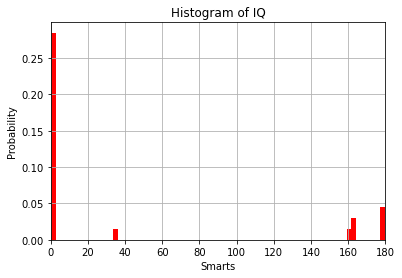

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(hr, 70, density=True, facecolor='r', alpha=1)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 180)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()